In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from classifier_selector import Classifier_selector
from sbs import SequentialBackwardSelection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from mpa import mpa
from sklearn.metrics import accuracy_score


In [2]:
''' Testing phase '''

' Testing phase '

In [3]:
classifier_selecting = Classifier_selector()

In [4]:
# Preprocessing

penguin_df = pd.read_csv("./Datasets/penguins.csv")
penguin_df.drop(columns = ["studyName", "Sample Number", "Region", "Island", "Stage", "Individual ID", "Clutch Completion", "Date Egg", "Sex", "Comments"], axis = 1,
                           inplace = True)

species = penguin_df.pop('Species')
penguin_df['Species'] = species
penguin_df = penguin_df.drop(penguin_df[penguin_df['Species']=='Gentoo penguin (Pygoscelis papua)'].index)

species_map = {'Adelie Penguin (Pygoscelis adeliae)':1, 'Chinstrap penguin (Pygoscelis antarctica)':0}
penguin_df.replace({"Species":species_map}, inplace = True)


def fill_nan_by_group(df, group_column, columns_to_fill=None):
    df_filled = df.copy()

    # If no columns specified, get all numeric columns except the group column
    if columns_to_fill is None:
        columns_to_fill = df.select_dtypes(include=[np.number]).columns
        columns_to_fill = columns_to_fill[columns_to_fill != group_column]

    # Fill each column separately
    for column in columns_to_fill:
        # Calculate means for each group for the current column
        group_means = df.groupby(group_column)[column].mean()

        # For each unique group, fill NaN values with that group's mean
        for group_value in df[group_column].unique():
            mask = (df[group_column] == group_value) & (df[column].isna())
            df_filled.loc[mask, column] = group_means[group_value]

    return df_filled
penguin_df = fill_nan_by_group(penguin_df, "Species")


train_df, test_df = train_test_split(penguin_df, test_size = 0.2)
X_train = train_df.drop("Species", axis = 1)
y_train = train_df["Species"]
X_test = test_df.drop("Species", axis = 1)
y_test = test_df["Species"]

/tmp/ipykernel_149543/1667827196.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  penguin_df.replace({"Species":species_map}, inplace = True)


In [5]:
penguin_df.isnull().sum()

Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Body Mass (g)          0
Delta 15 N (o/oo)      0
Delta 13 C (o/oo)      0
Species                0
dtype: int64

n_jobs = -1
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}

Best Cross-validation Score: 0.9962264150943396

Feature Importances: None

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        19
           1       0.86      1.00      0.93        25

    accuracy                           0.91        44
   macro avg       0.93      0.89      0.90        44
weighted avg       0.92      0.91      0.91        44



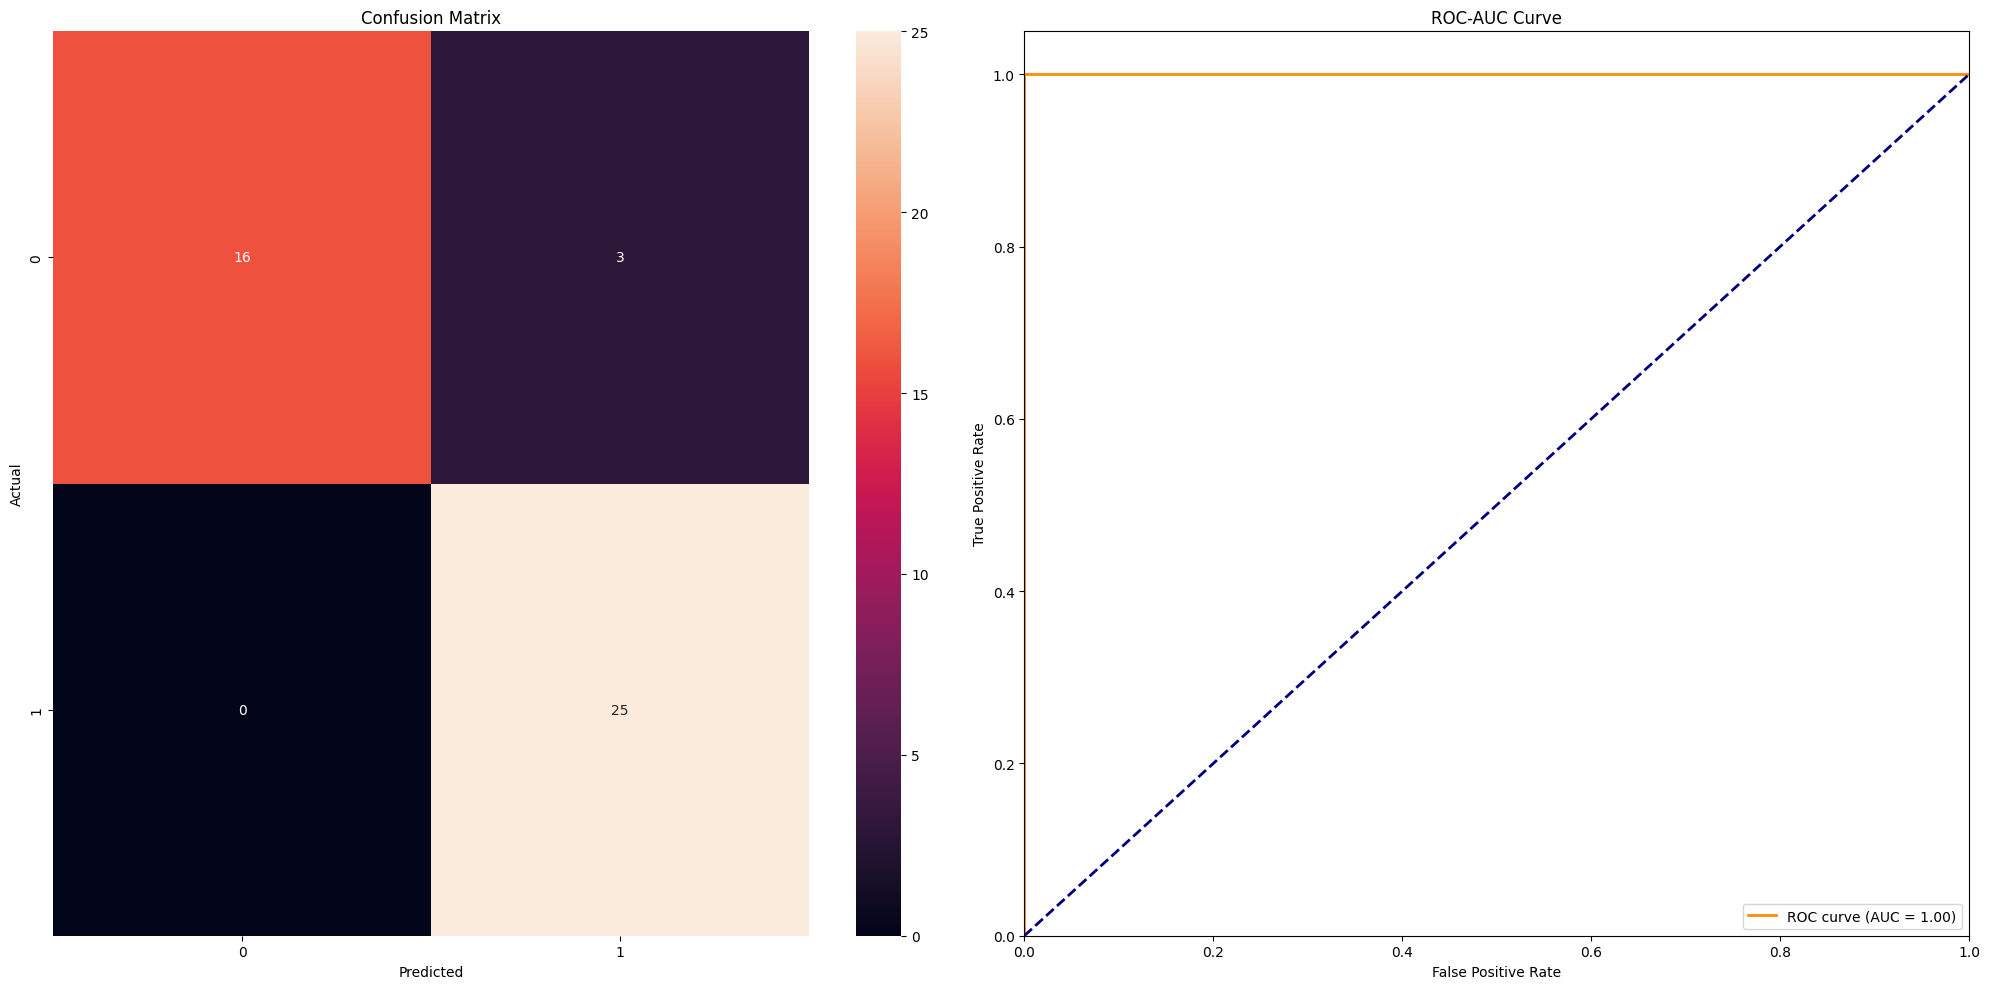

In [6]:
results_knn, scaler = classifier_selecting.optimize_classifier(X_train, X_test, y_train, y_test, 'knn')

print("\nBest Parameters:", results_knn['best_parameters'])
print("\nBest Cross-validation Score:", results_knn['best_score'])
print("\nFeature Importances:", results_knn['feature_importances'])
print("\nClassification Report:")
print(classification_report(y_test, results_knn['best_model'].predict(
    scaler.fit_transform(X_test))))

In [7]:
knn = KNeighborsClassifier(**results_knn['best_parameters'])

sbs_knn = SequentialBackwardSelection(estimator=knn,
                                      min_features = 3,
                                      scoring_metric=accuracy_score,
                                      scale_features=True,
                                      verbose=True)
sbs_knn.fit(X_train, X_test, y_train, y_test)


Removed feature: Flipper Length (mm)
Current performance: 0.95455
Remaining features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Culmen Depth (mm)
Current performance: 0.93182
Remaining features: ['Culmen Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Body Mass (g)
Current performance: 0.93182
Remaining features: ['Culmen Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']



n_jobs = -1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/soulangel443/.local/share/mise/installs/python/latest/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best Parameters: {'validation_fraction': 0.1, 'tol': 0.001, 'penalty': 'l1', 'max_iter': 500, 'early_stopping': True, 'alpha': 0.001}

Best Cross-validation Score: 0.9959183673469388

Feature Importances: {'Culmen Length (mm)': 6.4675027804077505, 'Culmen Depth (mm)': 1.7076488978990438, 'Flipper Length (mm)': 1.0773701252815782, 'Body Mass (g)': 1.6681463669242165, 'Delta 15 N (o/oo)': 0.0, 'Delta 13 C (o/oo)': 3.3724947151792675}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.96      1.00      0.98        25

    accuracy                           0.98        44
   macro avg       0.98      0.97      0.98        44
weighted avg       0.98      0.98      0.98        44



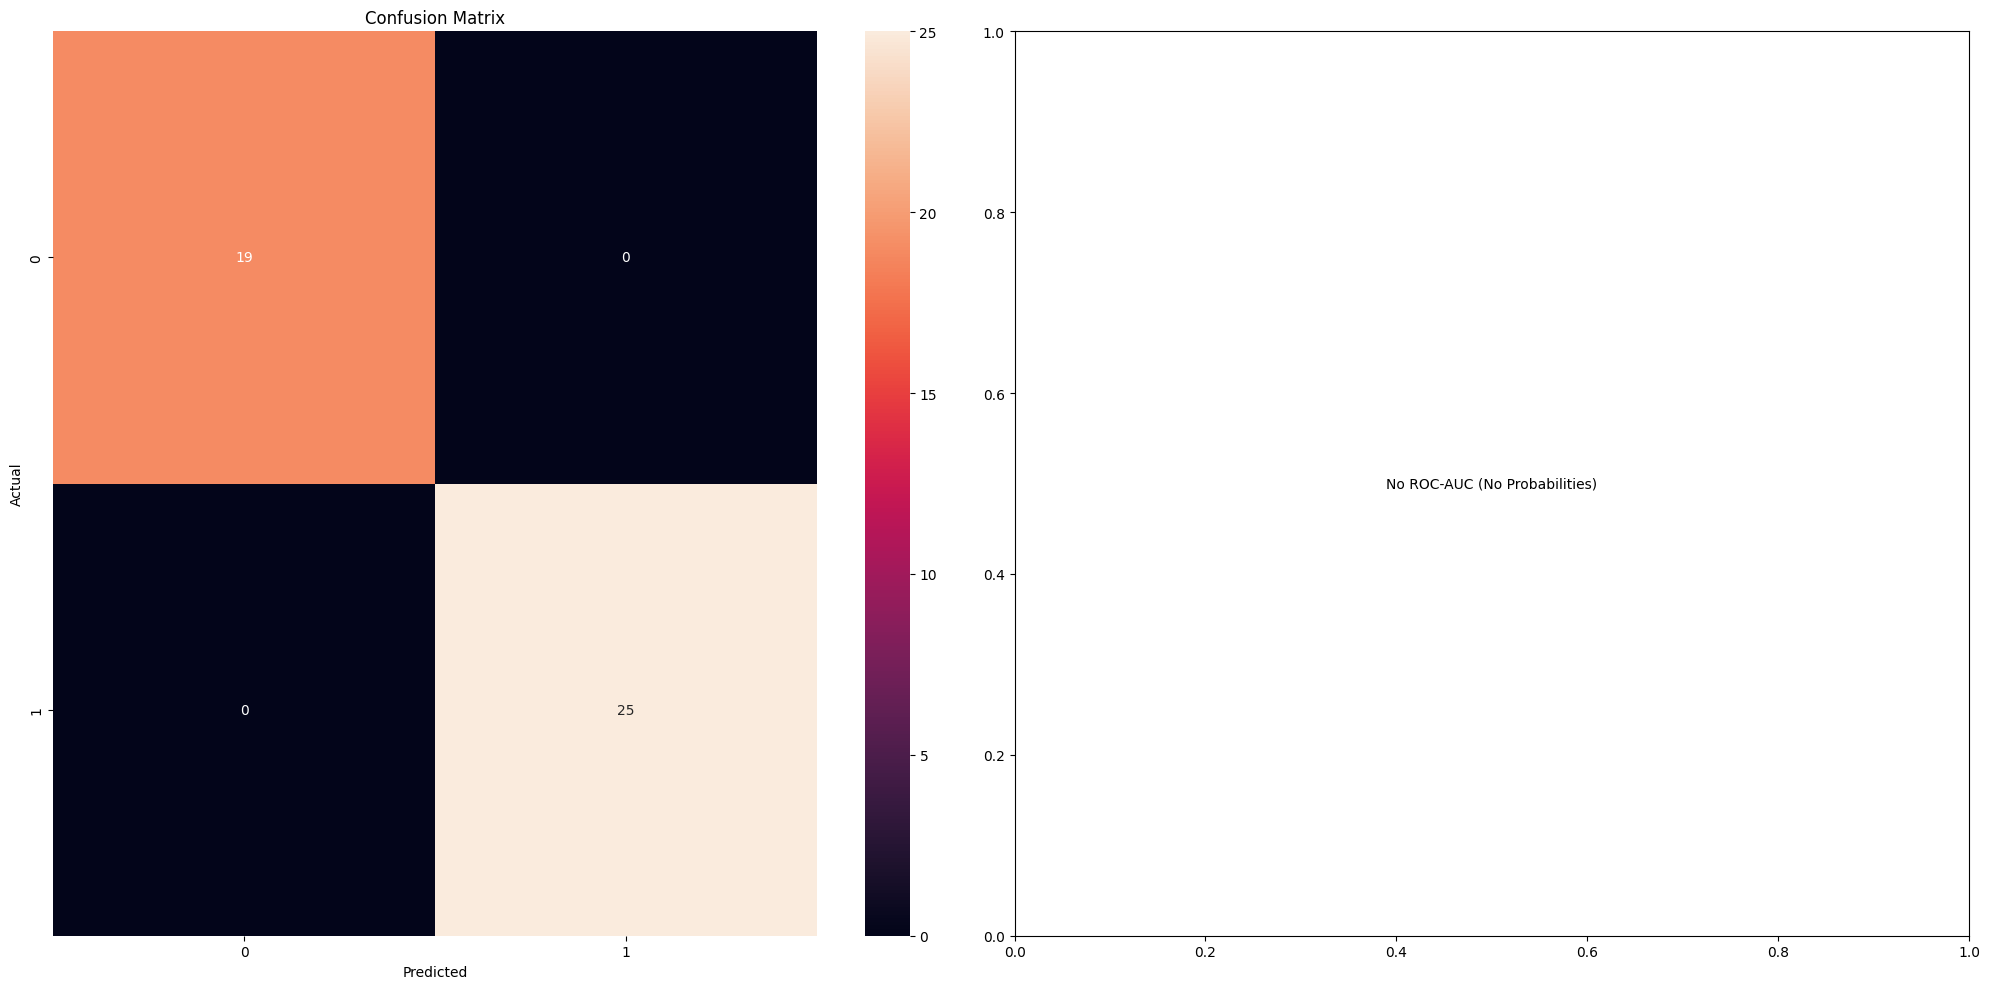

In [8]:
results_perceptron, scaler = classifier_selecting.optimize_classifier(X_train, X_test, y_train, y_test, 'perceptron')

print("\nBest Parameters:", results_perceptron['best_parameters'])
print("\nBest Cross-validation Score:", results_perceptron['best_score'])
print("\nFeature Importances:", results_perceptron['feature_importances'])
print("\nClassification Report:")
print(classification_report(y_test, results_perceptron['best_model'].predict(
    scaler.fit_transform(X_test))))

In [9]:
perceptron = Perceptron(**results_perceptron['best_parameters'])

sbs_perceptron = SequentialBackwardSelection(estimator=perceptron,
                                             min_features = 3,
                                             scoring_metric=accuracy_score,
                                             scale_features=True,
                                             verbose=True)
sbs_perceptron.fit(X_train, X_test, y_train, y_test)


Removed feature: Delta 13 C (o/oo)
Current performance: 0.97727
Remaining features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)']


Removed feature: Body Mass (g)
Current performance: 0.93182
Remaining features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)']


Removed feature: Delta 15 N (o/oo)
Current performance: 0.88636
Remaining features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)']



n_jobs = -1
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Best Cross-validation Score: 0.9882232138138274

Feature Importances: {'Culmen Length (mm)': 0.4840655217030369, 'Culmen Depth (mm)': 0.014193211644012708, 'Flipper Length (mm)': 0.05012254346230697, 'Body Mass (g)': 0.02463230923354129, 'Delta 15 N (o/oo)': 0.09130226303741429, 'Delta 13 C (o/oo)': 0.3356841509196879}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        19
           1       0.86      1.00      0.93        25

    accuracy                           0.91        44
   macro avg       0.93      0.89      0.90        44
weighted avg       0.92      0.91      0.91        44



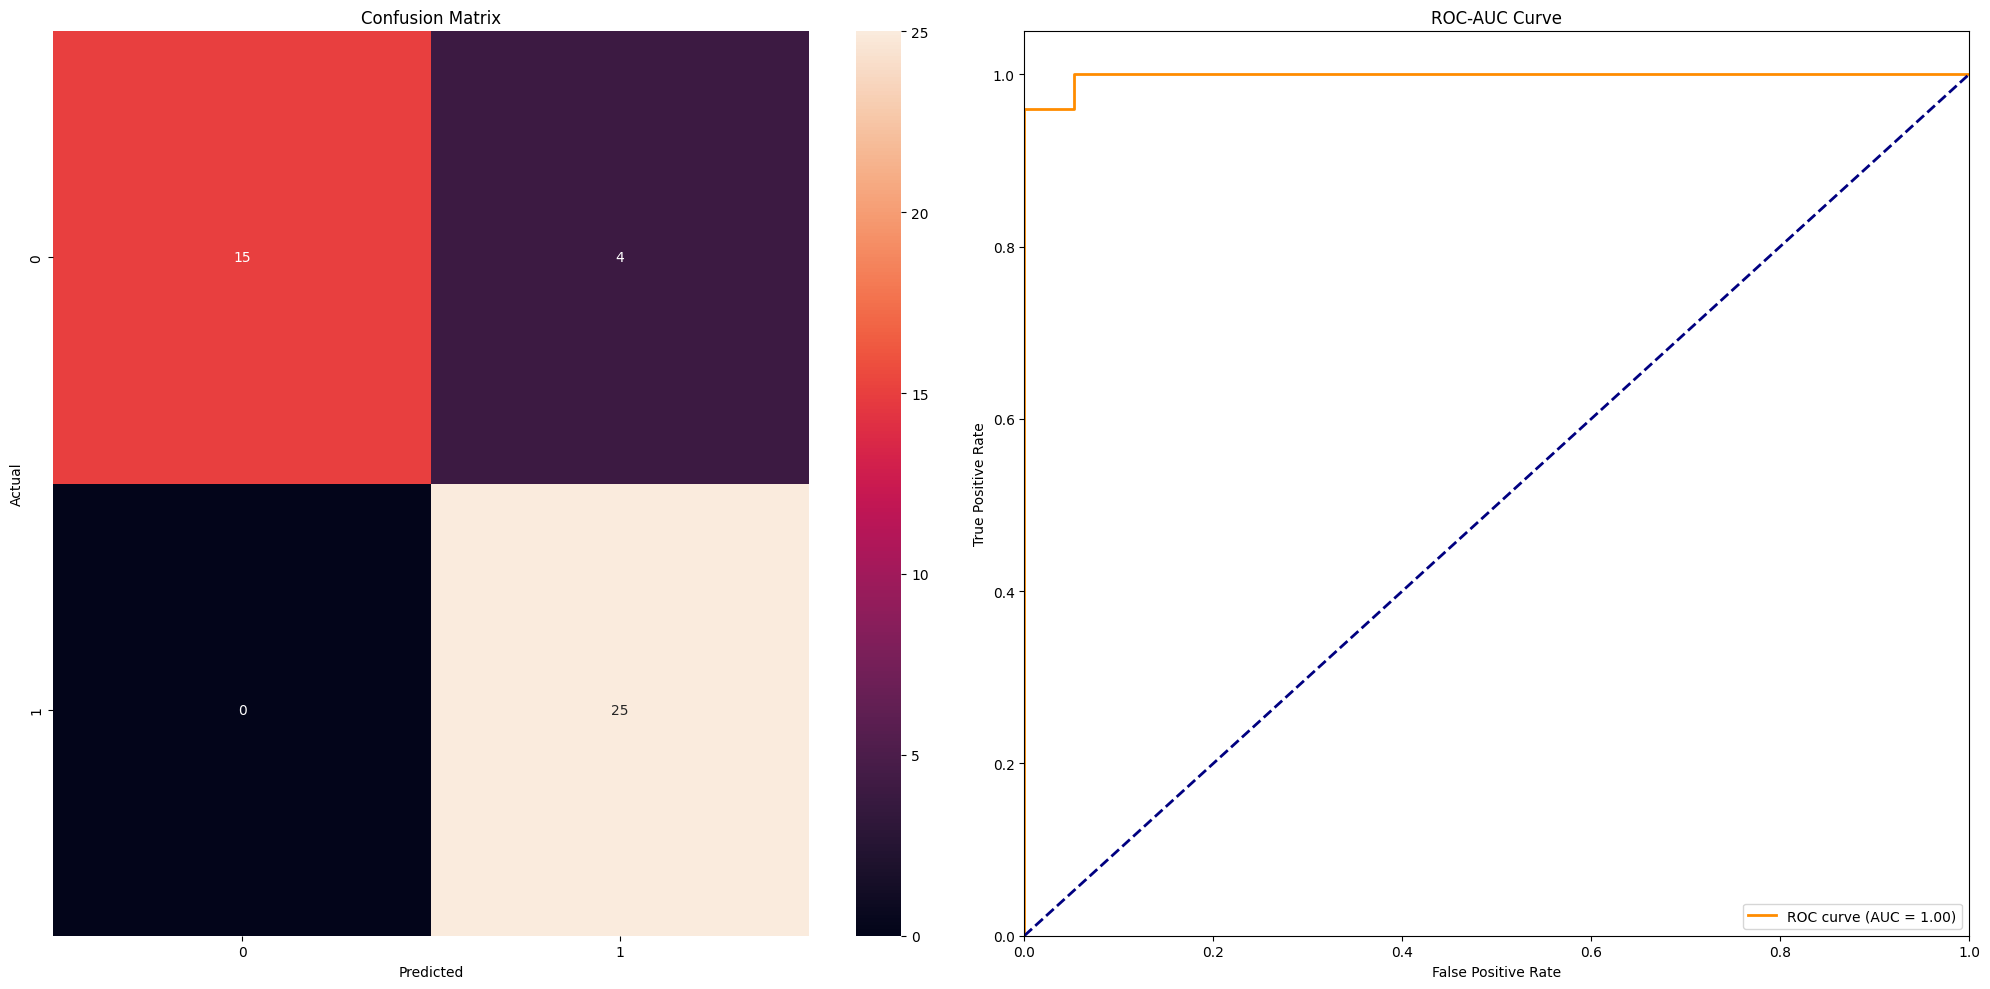

In [10]:
results_rf, scaler = classifier_selecting.optimize_classifier(X_train, X_test, y_train, y_test, 'rf')

print("\nBest Parameters:", results_rf['best_parameters'])
print("\nBest Cross-validation Score:", results_rf['best_score'])
print("\nFeature Importances:", results_rf['feature_importances'])
print("\nClassification Report:")
print(classification_report(y_test, results_rf['best_model'].predict(
    scaler.fit_transform(X_test))))

In [11]:
rf = RandomForestClassifier(**results_rf['best_parameters'])

sbs_rf = SequentialBackwardSelection(estimator=rf,
                                     min_features = 3,
                                     scoring_metric=accuracy_score,
                                     scale_features=True,
                                     verbose=True)
sbs_rf.fit(X_train, X_test, y_train, y_test)


Removed feature: Culmen Depth (mm)
Current performance: 0.90909
Remaining features: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Flipper Length (mm)
Current performance: 0.90909
Remaining features: ['Culmen Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Body Mass (g)
Current performance: 0.90909
Remaining features: ['Culmen Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']



n_jobs = -1
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'class_weight': 'balanced'}

Best Cross-validation Score: 0.9845893913120805

Feature Importances: {'Culmen Length (mm)': 0.9272736772535913, 'Culmen Depth (mm)': 0.04091986786774217, 'Flipper Length (mm)': 0.0, 'Body Mass (g)': 0.0, 'Delta 15 N (o/oo)': 4.6773556317619405e-15, 'Delta 13 C (o/oo)': 0.03180645487866176}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        19
           1       0.83      1.00      0.91        25

    accuracy                           0.89        44
   macro avg       0.92      0.87      0.88        44
weighted avg       0.91      0.89      0.88        44



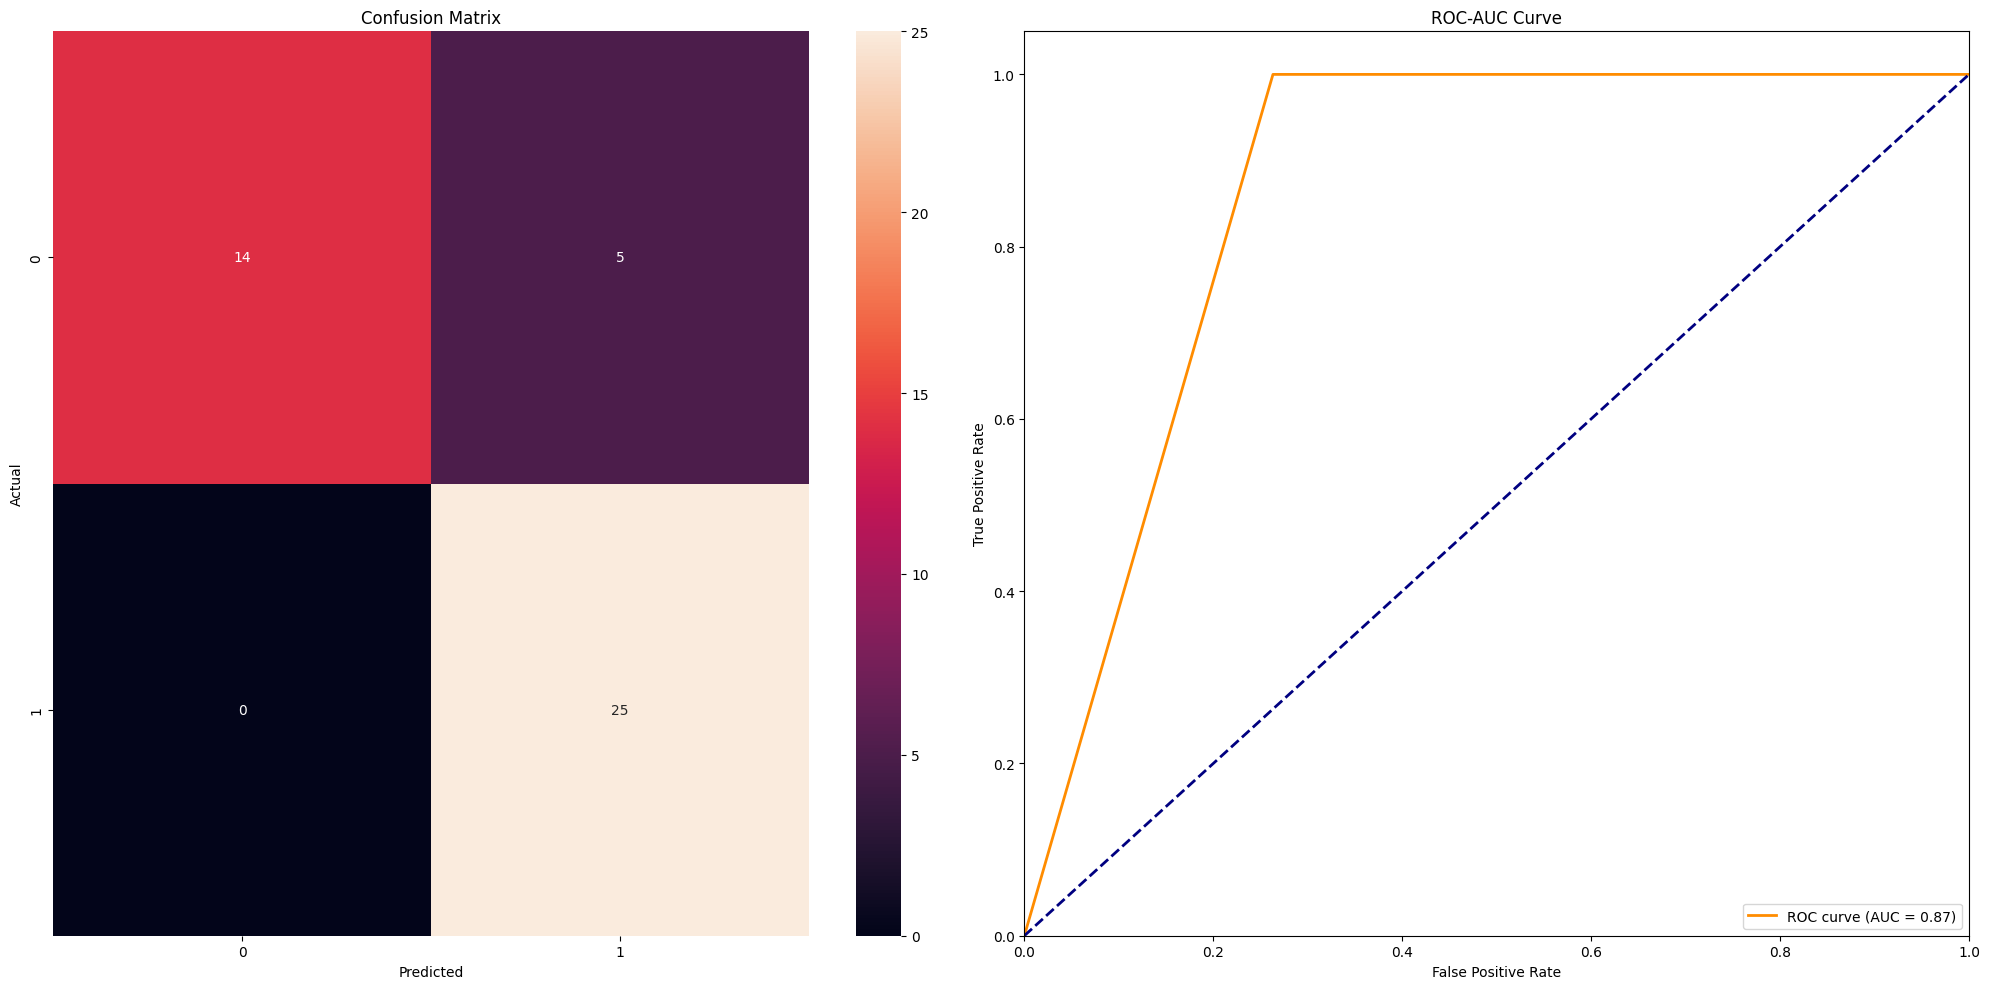

In [12]:
results_dt, scaler = classifier_selecting.optimize_classifier(X_train, X_test, y_train, y_test, 'dt')

print("\nBest Parameters:", results_dt['best_parameters'])
print("\nBest Cross-validation Score:", results_dt['best_score'])
print("\nFeature Importances:", results_dt['feature_importances'])
print("\nClassification Report:")
print(classification_report(y_test, results_dt['best_model'].predict(
    scaler.fit_transform(X_test))))

In [13]:
dt = DecisionTreeClassifier(**results_dt['best_parameters'])

sbs_dt = SequentialBackwardSelection(estimator=dt,
                                     min_features = 3,
                                     scoring_metric=accuracy_score,
                                     scale_features=True,
                                     verbose=True)
sbs_dt.fit(X_train, X_test, y_train, y_test)


Removed feature: Flipper Length (mm)
Current performance: 0.90909
Remaining features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Culmen Length (mm)
Current performance: 0.95455
Remaining features: ['Culmen Depth (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Culmen Depth (mm)
Current performance: 0.95455
Remaining features: ['Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']



n_jobs = -1
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'class_weight': 'balanced', 'C': 100}

Best Cross-validation Score: 1.0

Feature Importances: None

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        19
           1       0.86      1.00      0.93        25

    accuracy                           0.91        44
   macro avg       0.93      0.89      0.90        44
weighted avg       0.92      0.91      0.91        44



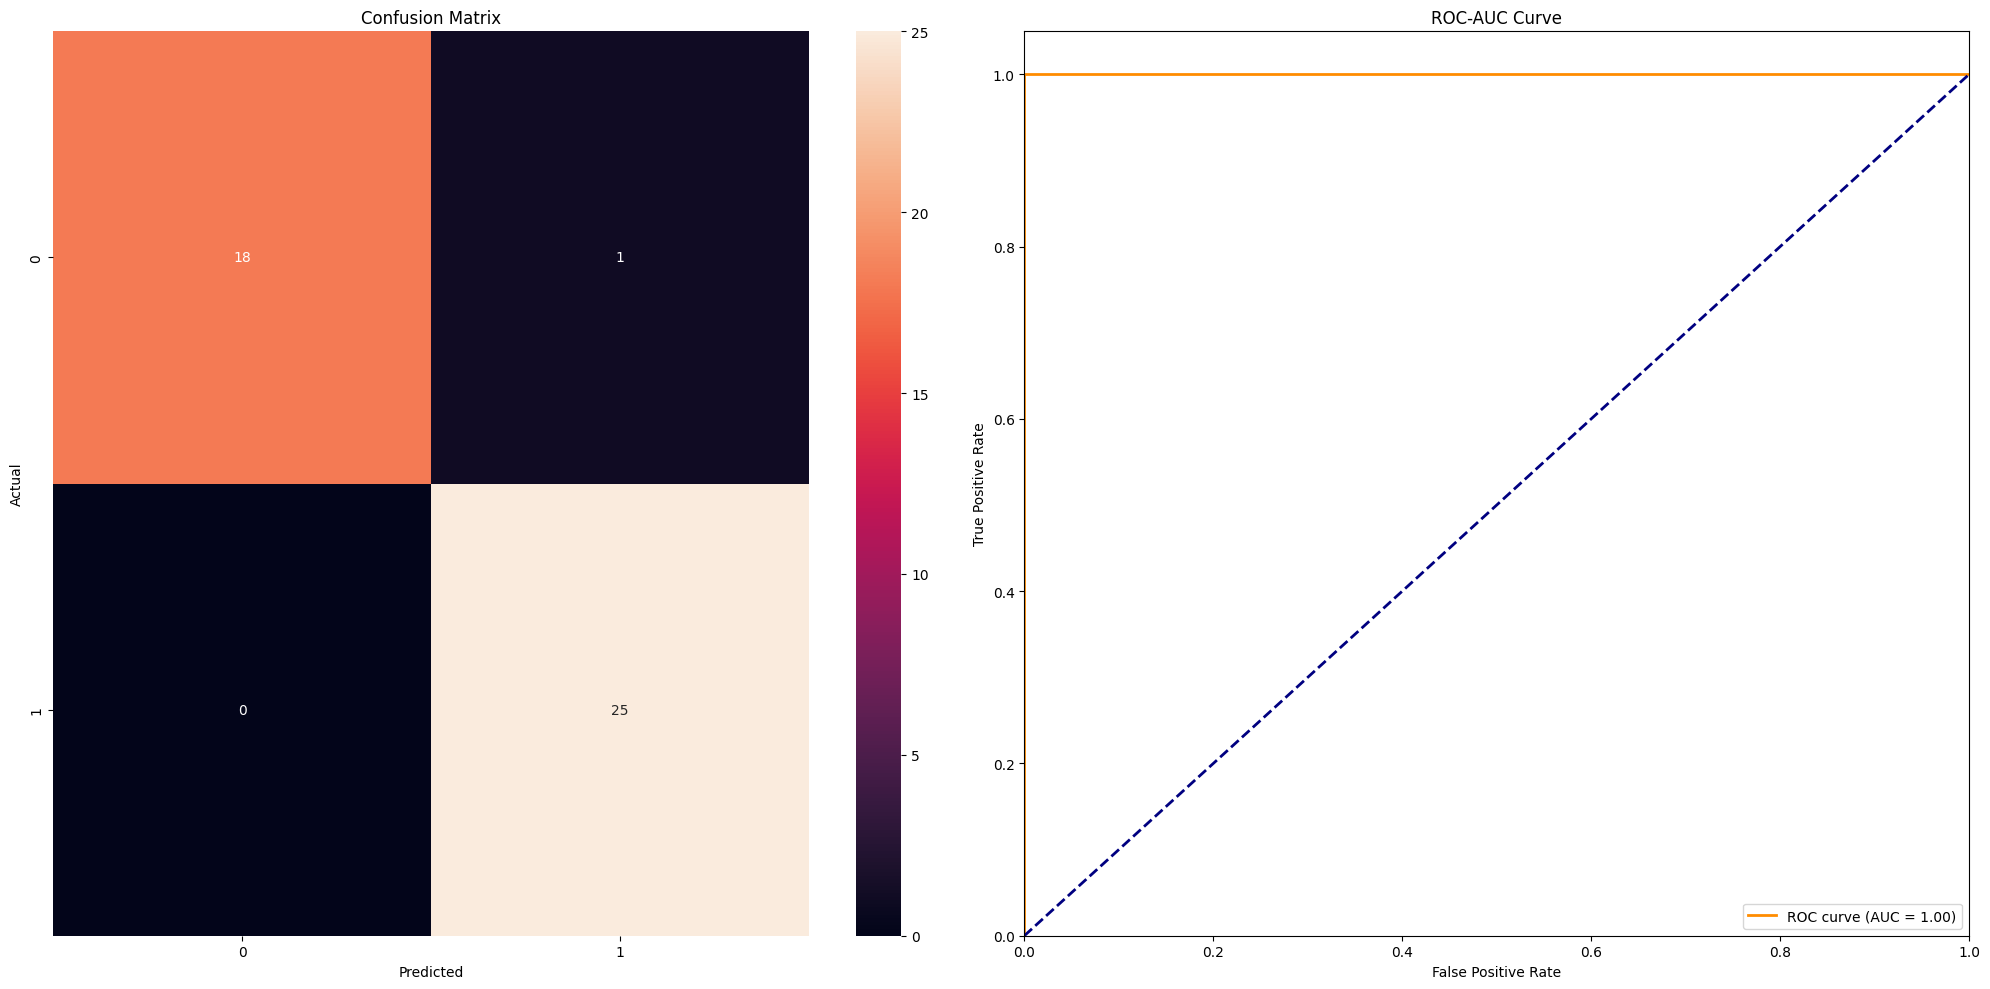

In [14]:
results_svm, scaler = classifier_selecting.optimize_classifier(X_train, X_test, y_train, y_test, 'svm')

print("\nBest Parameters:", results_svm['best_parameters'])
print("\nBest Cross-validation Score:", results_svm['best_score'])
print("\nFeature Importances:", results_svm['feature_importances'])
print("\nClassification Report:")
print(classification_report(y_test, results_svm['best_model'].predict(
    scaler.fit_transform(X_test))))

In [15]:
svm = SVC(**results_svm['best_parameters'])

sbs_svm = SequentialBackwardSelection(estimator=svm,
                                      min_features = 3,
                                      scoring_metric=accuracy_score,
                                      scale_features=True,
                                      verbose=True)
sbs_svm.fit(X_train, X_test, y_train, y_test)


Removed feature: Body Mass (g)
Current performance: 0.93182
Remaining features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Flipper Length (mm)
Current performance: 0.90909
Remaining features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


Removed feature: Culmen Depth (mm)
Current performance: 0.93182
Remaining features: ['Culmen Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']



In [16]:
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt


In [17]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class OptimizedBSpline(nn.Module):
    """Optimized B-spline with iterative De Boor algorithm"""
    def __init__(self, knots, degree=3):
        super().__init__()
        self.knots = knots
        self.degree = degree
        self.n_knots = len(knots)

    def _find_interval(self, t):
        """Find the knot interval index for each t value"""
        # Clamp t to valid range and find interval using searchsorted
        t_clamped = torch.clamp(t, self.knots[self.degree], self.knots[self.n_knots - self.degree - 1])
        i = torch.searchsorted(self.knots, t_clamped, right=True) - 1
        # Ensure i stays within valid bounds for degree-k spline
        return torch.clamp(i, self.degree, self.n_knots - self.degree - 1)

    def forward(self, t, control_points):
        """Iterative De Boor algorithm for B-spline evaluation"""
        batch_size = t.shape[0]
        n_control = len(control_points)
        k = self.degree

        # Find knot interval for each t
        interval = self._find_interval(t)  # Shape: [batch_size]

        # Initialize temporary control points for each t
        d = torch.zeros(batch_size, k + 1, device=t.device, dtype=t.dtype)
        for j in range(k + 1):
            idx = torch.clamp(interval - k + j, 0, n_control - 1)
            d[:, j] = control_points[idx]

        # Iterative De Boor computation
        for r in range(1, k + 1):
            for j in range(k, r - 1, -1):
                left_knot = self.knots[interval - k + j]
                right_knot = self.knots[interval - k + j + r]
                alpha = (t - left_knot) / (right_knot - left_knot + 1e-8)  # Add epsilon for stability
                d[:, j] = (1 - alpha) * d[:, j - 1] + alpha * d[:, j]

        return d[:, k]  # Final value for each t

class OptimizedTorchCubicSpline(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = nn.Parameter(y)
        n = len(x)
        self.register_buffer('knots', torch.cat([x[0].repeat(3), x[1:-1], x[-1].repeat(3)]))
        self.bspline = OptimizedBSpline(self.knots, degree=3)
        self.x_min = x[0]
        self.x_max = x[-1]

    def forward(self, t):
        return self.bspline(torch.clamp(t, self.x_min, self.x_max), self.y)

class OptimizedDifferentiablePchip(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = nn.Parameter(y)
        self.n = len(x) - 1

    def _compute_derivatives(self, y):
        dy = y[1:] - y[:-1]
        dx = self.x[1:] - self.x[:-1]
        slopes = dy / dx
        d = torch.zeros_like(y)
        for i in range(1, len(y)-1):
            if slopes[i-1] * slopes[i] > 0:
                w1 = 2*dx[i] + dx[i-1]
                w2 = dx[i] + 2*dx[i-1]
                d[i] = (w1 + w2) / (w1/slopes[i-1] + w2/slopes[i])
        d[0] = slopes[0]
        d[-1] = slopes[-1]
        return d

    def forward(self, t):
        idx = torch.clamp(torch.searchsorted(self.x, t) - 1, 0, self.n - 1)
        x0 = self.x[idx]
        x1 = self.x[idx + 1]
        y0 = self.y[idx]
        y1 = self.y[idx + 1]
        t_norm = (t - x0) / (x1 - x0)
        d = self._compute_derivatives(self.y)
        d0 = d[idx]
        d1 = d[idx + 1]
        t2 = t_norm * t_norm
        t3 = t2 * t_norm
        h00 = 2*t3 - 3*t2 + 1
        h10 = t3 - 2*t2 + t_norm
        h01 = -2*t3 + 3*t2
        h11 = t3 - t2
        dx_segment = x1 - x0
        return h00 * y0 + h10 * dx_segment * d0 + h01 * y1 + h11 * dx_segment * d1

class OptimizedPyTorchGradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, smoothing_factor=0.0001, spline_type='cubic',
                 device=None, track_history=False, optimizer_type='adam', scheduler_type='reduce_on_plateau'):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.track_history = track_history
        self.optimizer_type = optimizer_type
        self.scheduler_type = scheduler_type

        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be 'cubic' or 'pchip'")
        torch.manual_seed(random_state)
        np.random.seed(random_state)

    def _to_tensor(self, data, dtype=torch.float32):
        if isinstance(data, torch.Tensor):
            return data.to(self.device, dtype=dtype, non_blocking=True)
        return torch.tensor(data, dtype=dtype, device=self.device)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = torch.mean(X[mask_1], dim=0)
        self.m0 = torch.mean(X[~mask_1], dim=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1
        self.spline_models = nn.ModuleList()
        for i in range(n_features):
            x_min, x_max = X[:, i].min().item(), X[:, i].max().item()
            control_x = torch.linspace(x_min, x_max, self.n_control_points, device=self.device)
            y_min, y_max = X[:, -1].min().item(), X[:, -1].max().item()
            y_mid = (self.m0[-1] + self.m1[-1]) / 2
            y_range = y_max - y_min
            control_y = torch.empty(self.n_control_points, device=self.device).uniform_(
                y_mid - y_range * 0.05, y_mid + y_range * 0.05
            )
            if self.spline_type == 'cubic':
                spline = OptimizedTorchCubicSpline(control_x, control_y).to(self.device)
            else:
                spline = OptimizedDifferentiablePchip(control_x, control_y).to(self.device)
            self.spline_models.append(spline)
        self.initial_control_points = [(m.x.clone(), m.y.clone()) for m in self.spline_models]

    def _calculate_displacement(self, X):
        total_spline = sum(spline(X[:, i]) for i, spline in enumerate(self.spline_models))
        return X[:, -1] - total_spline

    def _update_pseudo_labels(self, X, y):
        m1_displacement = self._calculate_displacement(self.m1.unsqueeze(0))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return torch.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _create_optimizer_and_scheduler(self):
        params = [p for spline in self.spline_models for p in spline.parameters()]
        if self.optimizer_type.lower() == 'adam':
            optimizer = torch.optim.Adam(params, lr=self.initial_learning_rate)
        else:
            optimizer = torch.optim.SGD(params, lr=self.initial_learning_rate)
        if self.scheduler_type.lower() == 'reduce_on_plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=self.decay_factor,
                patience=self.patience, min_lr=self.min_learning_rate)
        elif self.scheduler_type.lower() == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=self.patience, gamma=self.decay_factor
            )
        else:
            scheduler = None
        return optimizer, scheduler

    def fit(self, X, y):
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] < 2:
            raise ValueError("At least 2 features required")

        X_tensor = self._to_tensor(X)
        y_tensor = self._to_tensor(y, dtype=torch.long)

        with torch.no_grad():
            self._calculate_class_means(X_tensor, y_tensor)
            self._initialize_control_points(X_tensor)

        optimizer, scheduler = self._create_optimizer_and_scheduler()

        best_error = float('inf')
        best_control_ys = [spline.y.clone() for spline in self.spline_models]
        best_class_1_pseudo = None

        if self.track_history:
            self.error_history_ = []
            self.control_point_history = [self.initial_control_points]

        for epoch in range(self.epochs):
            pseudo_labels = self._update_pseudo_labels(X_tensor, y_tensor)
            displacements = self._calculate_displacement(X_tensor)

            errors = displacements * pseudo_labels <= 0
            error_count = errors.sum().item()

            if self.verbose and epoch % 5 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_ys = [spline.y.clone() for spline in self.spline_models]
                best_class_1_pseudo = self.class_1_pseudo
                self.best_epoch = epoch
                if error_count == 0 and epoch > 10:
                    if self.verbose:
                        print(f"Perfect separation achieved at epoch {epoch}")
                    break

            if self.track_history:
                self.error_history_.append(error_count)
                self.control_point_history.append(
                    [(s.x.clone().cpu().numpy(), s.y.clone().detach().cpu().numpy())
                     for s in self.spline_models]
                )

            if error_count == 0:
                continue

            error_indices = torch.where(errors)[0]
            X_err = X_tensor[error_indices]
            y_err = y_tensor[error_indices]
            ti = torch.where(y_err == 1, 1, -1)

            spline_values = sum(spline(X_err[:, i]) for i, spline in enumerate(self.spline_models))
            loss = torch.mean(torch.relu(1.0 - ti * self.class_1_pseudo * (X_err[:, -1] - spline_values)))

            if self.lambda_reg > 0:
                smoothness_penalty = 0
                for spline in self.spline_models:
                    y_diff = spline.y[1:] - spline.y[:-1]
                    x_diff = spline.x[1:] - spline.x[:-1]
                    smoothness_penalty += torch.mean((y_diff / (x_diff + 1e-8))**2)
                loss += self.lambda_reg * smoothness_penalty

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            if scheduler is None:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(error_count)
                else:
                    scheduler.step()
                if optimizer.param_groups[0]['lr'] <= self.min_learning_rate:
                    if self.verbose:
                        print(f"Minimum learning rate reached at epoch {epoch}")
                    break

        for spline, best_y in zip(self.spline_models, best_control_ys):
            spline.y.data = best_y
        self.class_1_pseudo = best_class_1_pseudo
        return self

    def predict(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        predictions = torch.where(displacements > 0,
                                torch.tensor(1 if self.class_1_pseudo > 0 else 0, device=self.device),
                                torch.tensor(0 if self.class_1_pseudo > 0 else 1, device=self.device))
        return predictions.cpu().numpy()

    def predict_proba(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        raw_probs = 1 / (1 + torch.exp(-displacements * self.class_1_pseudo * 0.5))
        if self.class_1_pseudo > 0:
            probs = torch.column_stack([1 - raw_probs, raw_probs])
        else:
            probs = torch.column_stack([raw_probs, 1 - raw_probs])
        return probs.cpu().numpy()

    def plot_convergence(self, figsize=(10, 4)):
        if not self.track_history or not hasattr(self, 'error_history_'):
            print("Convergence plotting requires track_history=True and a fitted model.")
            return None

        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.error_history_, 'b-', label='Errors')
        ax.set_title('Error Convergence')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Number of Errors')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        return fig

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def reorder_least_correlated_feature(X, standardize=True, feature_order=None, scaler=None):
    """
    Reorder X based on correlation or a provided feature order, applying standardization if specified.

    Parameters:
    - X: numpy array or pandas DataFrame
    - standardize: bool
    - feature_order: list, optional order from training set (default: None, compute from X)
    - scaler: StandardScaler instance, optional for test set standardization (default: None)

    Returns:
    - X_reordered, feature_order, scaler (scaler is None if feature_order is provided and not used)
    """
    is_dataframe = isinstance(X, pd.DataFrame)
    if is_dataframe:
        column_names = X.columns
        X_np = X.to_numpy()
    else:
        X_np = np.asarray(X)

    if feature_order is None:
        # Training case: compute order and standardize
        if standardize:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_np)
        else:
            X_scaled = X_np.copy()

        corr_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
        n_features = X_np.shape[1]
        avg_corr = (np.sum(corr_matrix, axis=1) - np.diag(corr_matrix)) / (n_features - 1)
        target_idx = np.argmin(avg_corr)
        feature_order = list(range(n_features))
        feature_order.pop(target_idx)
        feature_order.append(target_idx)

        if is_dataframe:
            X_reordered = pd.DataFrame(X_scaled[:, feature_order],
                                      columns=[column_names[i] for i in feature_order])
        else:
            X_reordered = X_scaled[:, feature_order]
    else:
        # Test case: use provided order and standardize with provided scaler if given
        if standardize and scaler is not None:
            X_scaled = scaler.transform(X_np)
            if is_dataframe:
                X_reordered = pd.DataFrame(X_scaled[:, feature_order],
                                         columns=[column_names[i] for i in feature_order])
            else:
                X_reordered = X_scaled[:, feature_order]
        else:
            # No standardization, just reorder
            if is_dataframe:
                X_reordered = X.iloc[:, feature_order]
            else:
                X_reordered = X_np[:, feature_order]
        scaler = None  # No new scaler created

    return X_reordered, feature_order, scaler

# Updated usage
X_train_reordered, feature_order, scaler = reorder_least_correlated_feature(X_train)
print(f"Train - Means: {X_train_reordered.mean(axis=0).round(2)}, "
      f"Stds: {X_train_reordered.std(axis=0).round(2)}")
X_test_reordered, _, _ = reorder_least_correlated_feature(X_test, feature_order=feature_order, scaler=scaler)
print(f"Test - Means: {X_test_reordered.mean(axis=0).round(2)}, "
      f"Stds: {X_test_reordered.std(axis=0).round(2)}")

Train - Means: Culmen Length (mm)    -0.0
Flipper Length (mm)   -0.0
Body Mass (g)         -0.0
Delta 15 N (o/oo)      0.0
Delta 13 C (o/oo)      0.0
Culmen Depth (mm)      0.0
dtype: float64, Stds: Culmen Length (mm)     1.0
Flipper Length (mm)    1.0
Body Mass (g)          1.0
Delta 15 N (o/oo)      1.0
Delta 13 C (o/oo)      1.0
Culmen Depth (mm)      1.0
dtype: float64
Test - Means: Culmen Length (mm)     0.29
Flipper Length (mm)    0.08
Body Mass (g)          0.12
Delta 15 N (o/oo)      0.23
Delta 13 C (o/oo)      0.20
Culmen Depth (mm)      0.07
dtype: float64, Stds: Culmen Length (mm)     0.97
Flipper Length (mm)    1.01
Body Mass (g)          1.06
Delta 15 N (o/oo)      0.89
Delta 13 C (o/oo)      1.01
Culmen Depth (mm)      0.93
dtype: float64


In [20]:
X_train_reordered = X_train_reordered.to_numpy()
X_test_reordered = X_test_reordered.to_numpy()

In [21]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [22]:
type(X_train_reordered)
type(y_train)

numpy.ndarray

/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
  idx = torch.clamp(torch.searchsorted(self.x, t) - 1, 0, self.n - 1)


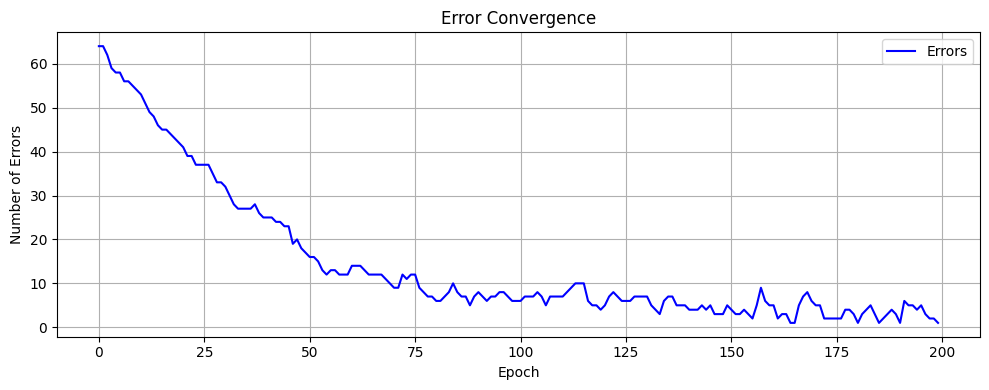

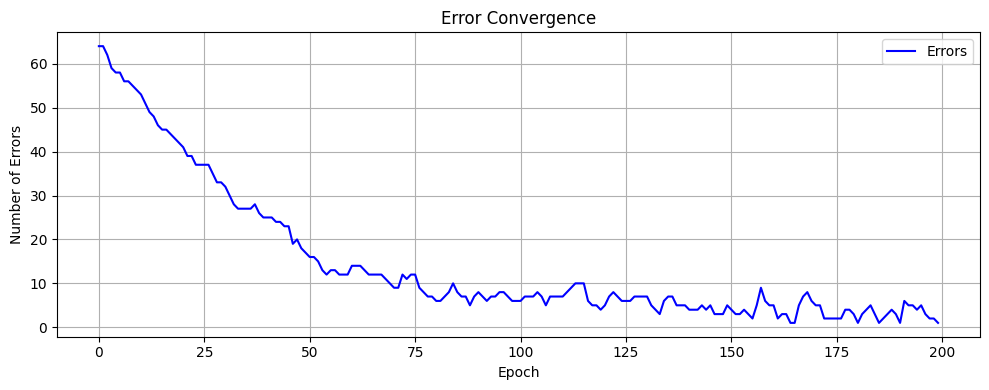

In [23]:
model = OptimizedPyTorchGradientSMPA(
    learning_rate=0.01,
    epochs=200,
    n_control_points=8,
    spline_type='pchip',
    device='cpu',  # Will use GPU if available
    track_history=True,
    random_state = 44,
    decay_factor=0.99
)

# Train model
model.fit(X_train_reordered, y_train)

model.plot_convergence()

In [24]:
from sklearn.metrics import f1_score

score = model.score(X_test_reordered, y_test)
print(score)
f1 = f1_score(y_test, model.predict(X_test_reordered))
print(f1)
from sklearn.metrics import classification_report
print(classification_report(y_test,model.predict(X_test_reordered)))
cr = classification_report(y_test, model.predict(X_test_reordered))

0.8409090909090909
0.8679245283018868
              precision    recall  f1-score   support

           0       0.88      0.74      0.80        19
           1       0.82      0.92      0.87        25

    accuracy                           0.84        44
   macro avg       0.85      0.83      0.83        44
weighted avg       0.84      0.84      0.84        44



In [25]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [26]:
param_grid = {
                'learning_rate': [0.01, 0.001, 0.02, 0.00001],           # Range to balance step size
                'epochs': [300],                         # Enough iterations to converge
                'n_control_points': [5, 8, 9, 15, 20],              # More points to capture wiggles
                'spline_type': ['pchip','cubic'],            # Test both spline types
                'patience': [15],                             # Fixed patience for consistency
                'decay_factor': [0.99],                        # Fixed decay for simplicity
                'min_learning_rate': [1.e-6],
                'smoothing_factor': [0.00000001, 0.000001]

}
smpa = OptimizedPyTorchGradientSMPA(random_state=12, track_history=True, device='cpu')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
grid_search = GridSearchCV(smpa, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=3)
grid_search.fit(X_train_reordered, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor t

[CV 3/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-08, spline_type=pchip;, score=0.962 total time=   6.0s


/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor t

[CV 3/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-06, spline_type=pchip;, score=0.941 total time=   1.4s
[CV 5/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-08, spline_type=pchip;, score=0.980 total time=   4.9s
[CV 5/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-06, spline_type=pchip;, score=0.980 total time=   1.0s
[CV 1/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-08, spline_type=pchip;, score=0.962 total time=   6.9s


/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)


[CV 4/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-08, spline_type=pchip;, score=0.980 total time=   6.6s
[CV 4/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-06, spline_type=pchip;, score=0.980 total time=   1.7s
[CV 2/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-06, spline_type=pchip;, score=0.926 total time=   7.7s
[CV 2/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-08, spline_type=pchip;, score=0.943 total time=   8.1s
[CV 4/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-08, spline_type=cubic;, score=0.960 total time=   9.5s


/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)


[CV 2/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-08, spline_type=cubic;, score=1.000 total time=   9.3s


/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)


[CV 5/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-08, spline_type=cubic;, score=0.962 total time=   8.9s


/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)


[CV 5/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-06, spline_type=cubic;, score=1.000 total time=   1.4s
[CV 1/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-06, spline_type=pchip;, score=0.962 total time=   7.0s
[CV 2/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=8, patience=15, smoothing_factor=1e-08, spline_type=pchip;, score=0.963 total time=   1.9s
[CV 1/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=8, patience=15, smoothing_factor=1e-08, spline_type=pchip;, score=0.962 total time=   2.3s
[CV 5/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=8, patience=15, smoothing_factor=1e-08, spline_type=pchip;, score=0.980 total time=   1.0s
[CV 3/5] END de

/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)


[CV 1/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=5, patience=15, smoothing_factor=1e-06, spline_type=cubic;, score=0.980 total time=  28.1s
[CV 2/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=8, patience=15, smoothing_factor=1e-08, spline_type=cubic;, score=0.981 total time=  23.9s
[CV 4/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=9, patience=15, smoothing_factor=1e-08, spline_type=pchip;, score=0.980 total time=   3.4s
[CV 3/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=8, patience=15, smoothing_factor=1e-08, spline_type=cubic;, score=1.000 total time=  24.2s
[CV 4/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=8, patience=15, smoothing_factor=1e-08, spline_type=cubic;, score=0.936 total time=  24.8s
[CV 3/5] END de

/tmp/ipykernel_149543/810629333.py:83: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)


[CV 2/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=9, patience=15, smoothing_factor=1e-06, spline_type=pchip;, score=0.963 total time=   2.7s
[CV 1/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=8, patience=15, smoothing_factor=1e-08, spline_type=cubic;, score=0.962 total time=  30.6s
[CV 5/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=9, patience=15, smoothing_factor=1e-06, spline_type=pchip;, score=0.962 total time=   3.0s
[CV 4/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=8, patience=15, smoothing_factor=1e-06, spline_type=cubic;, score=0.913 total time=  26.7s
[CV 4/5] END decay_factor=0.99, epochs=300, learning_rate=0.01, min_learning_rate=1e-06, n_control_points=9, patience=15, smoothing_factor=1e-06, spline_type=pchip;, score=0.980 total time=   3.8s
[CV 3/5] END de

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=OptimizedPyTorchGradientSMPA(device='cpu',
                                                    random_state=12,
                                                    track_history=True),
             n_jobs=-1,
             param_grid={'decay_factor': [0.99], 'epochs': [300],
                         'learning_rate': [0.01, 0.001, 0.02, 1e-05],
                         'min_learning_rate': [1e-06],
                         'n_control_points': [5, 8, 9, 15, 20],
                         'patience': [15], 'smoothing_factor': [1e-08, 1e-06],
                         'spline_type': ['pchip', 'cubic']},
             scoring='f1', verbose=3)

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.79      0.88        19
           1       0.86      1.00      0.93        25

    accuracy                           0.91        44
   macro avg       0.93      0.89      0.90        44
weighted avg       0.92      0.91      0.91        44

Best CV score:  0.9808361080281169


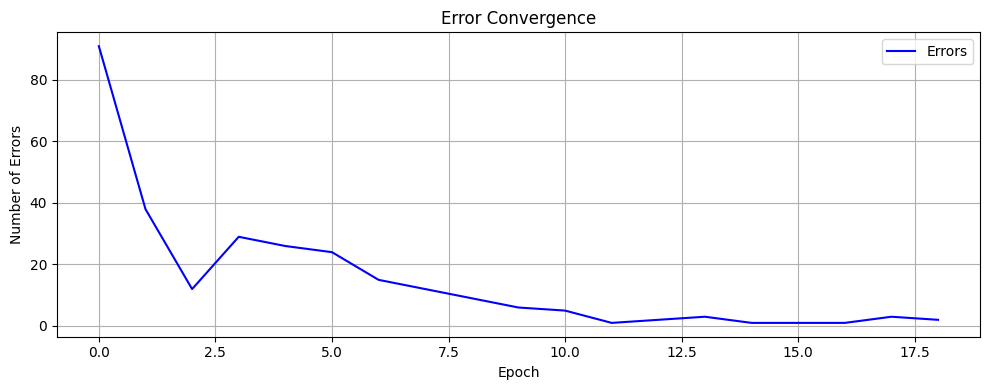

In [27]:
cr = classification_report(y_test, grid_search.best_estimator_.predict(X_test_reordered))
print("Classification report \n", cr)
print("Best CV score: ", grid_search.best_score_)

fig = grid_search.best_estimator_.plot_convergence()
plt.show()

In [28]:
grid_search.best_params_

{'decay_factor': 0.99,
 'epochs': 300,
 'learning_rate': 1e-05,
 'min_learning_rate': 1e-06,
 'n_control_points': 5,
 'patience': 15,
 'smoothing_factor': 1e-06,
 'spline_type': 'cubic'}

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_spline_pairs(model, X, y, feature_names=None, figsize=(12, 8)):
    """
    Plot feature vs. target feature with fitted splines for an OptimizedPyTorchGradientSMPA model.

    Parameters:
    - model: Trained OptimizedPyTorchGradientSMPA instance
    - X: Input data (numpy array or torch tensor), shape [n_samples, n_features]
    - y: Target labels (numpy array or torch tensor), shape [n_samples]
    - feature_names: Optional list of feature names for labeling (length n_features)
    - figsize: Tuple for figure size (width, height)
    """
    # Convert inputs to numpy for plotting
    if isinstance(X, torch.Tensor):
        X = X.cpu().detach().numpy()
    if isinstance(y, torch.Tensor):
        y = y.cpu().detach().numpy()

    n_features = X.shape[1]
    target_idx = n_features - 1
    n_plots = n_features - 1

    # Diagnostic: Print min/max of each feature
    print("Feature ranges in X passed to plot_spline_pairs:")
    for i in range(n_features):
        print(f"{'Target' if i == target_idx else f'Feature {i}'}: "
              f"min={X[:, i].min():.2f}, max={X[:, i].max():.2f}")

    # Set up figure
    rows = int(np.ceil(n_plots / 2))
    cols = min(2, n_plots)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    # Default feature names if none provided
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(n_features)]

    # Move spline models to CPU for evaluation
    model_device = model.device
    for spline in model.spline_models:
        spline.to('cpu')

    for i in range(n_plots):
        ax = axes[i]
        feature = X[:, i]
        target = X[:, target_idx]

        # Scatter plot: feature vs. target, colored by class
        scatter = ax.scatter(feature, target, c=y, cmap='viridis', alpha=0.6)
        plt.colorbar(scatter, ax=ax, label='Class')

        # Generate points for spline evaluation (in standardized scale)
        x_range = np.linspace(feature.min(), feature.max(), 200)
        x_tensor = torch.tensor(x_range, dtype=torch.float32)

        # Evaluate the spline
        spline_output = model.spline_models[i](x_tensor).detach().numpy()

        # Plot the spline
        ax.plot(x_range, spline_output, 'r-', label='Fitted Spline', linewidth=2)

        # Reference line
        ax.axhline(0, color='k', linestyle='--', alpha=0.3, label='Zero Line')

        # Labeling
        ax.set_xlabel(feature_names[i])
        ax.set_ylabel(feature_names[target_idx])
        ax.set_title(f'{feature_names[i]} vs. {feature_names[target_idx]}')
        ax.legend()

    # Hide unused subplots
    for j in range(n_plots, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Restore spline models to original device
    for spline in model.spline_models:
        spline.to(model_device)

Feature ranges in X passed to plot_spline_pairs:
Feature 0: min=-1.73, max=3.00
Feature 1: min=-2.73, max=2.83
Feature 2: min=-2.33, max=2.50
Feature 3: min=-2.78, max=2.22
Feature 4: min=-1.78, max=2.19
Target: min=-2.37, max=2.62


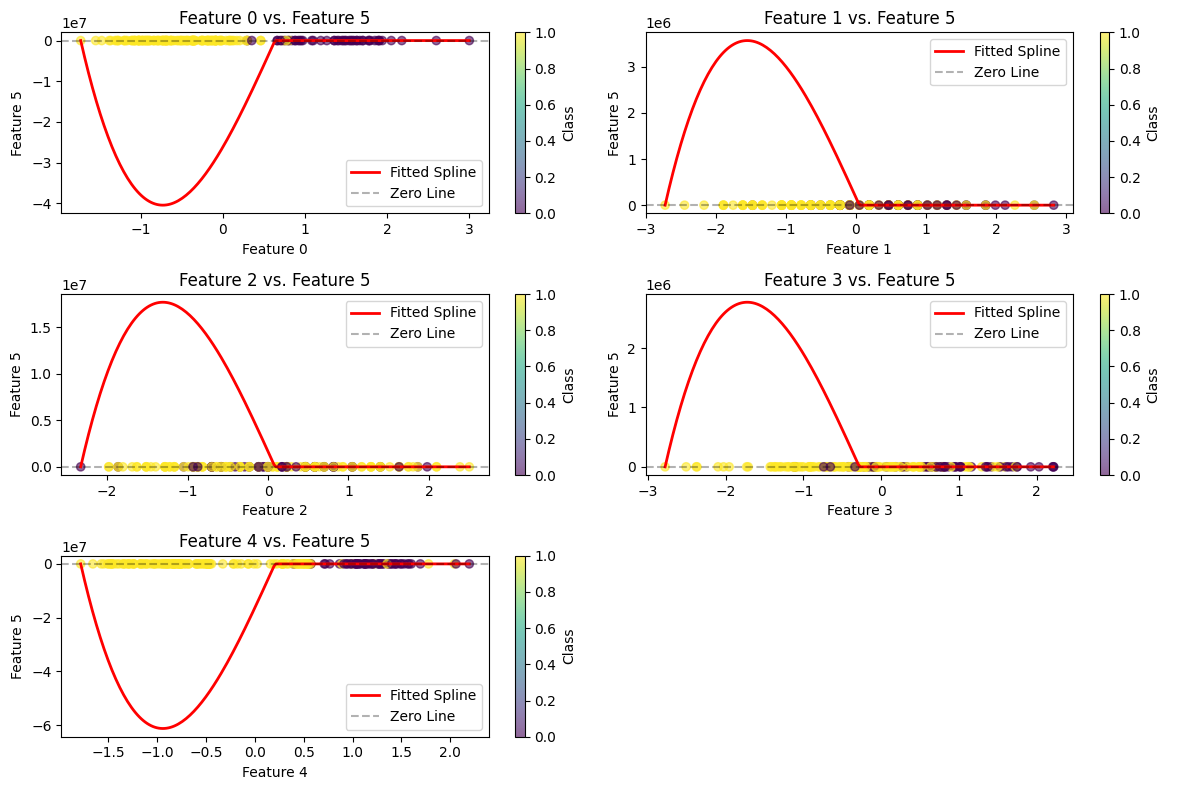

In [30]:
plot_spline_pairs(grid_search.best_estimator_, X_train_reordered, y_train)